# demo_run.ipynb 示例

本笔记演示 CellType-GP 的完整流程：载入预处理的空间转录组数据、运行解卷积模型，并与 Xenium 真值打分进行对比评估。

## 1. 环境与路径

若仓库克隆在其他目录，请先更新基础路径。本示例假设工作目录为 `/home/vs_theg/ST_program/CellType_GP`，其中 `data` 子目录需要包含 `/home/vs_theg/ST_program/CellType_GP/data/spot_data_full.npz` 以及对应真值 CSV。


In [103]:
from pathlib import Path
import pandas as pd

project_root = Path('/home/vs_theg/ST_program/CellType_GP')
package_dir = project_root / 'src'
data_dir = project_root / 'data'
output_dir = data_dir / 'notebook_outputs'
output_dir.mkdir(exist_ok=True, parents=True)

print(f'Project root: {project_root}')
print(f'Package dir : {package_dir}')
print(f'Data dir    : {data_dir}')

Project root: /home/vs_theg/ST_program/CellType_GP
Package dir : /home/vs_theg/ST_program/CellType_GP/src
Data dir    : /home/vs_theg/ST_program/CellType_GP/data


## 2. 查看输入矩阵

加载 NPZ 数据包，其中存放 Gene Program 得分 (`visium_score`) 与细胞类型比例 (`spot_cluster_fraction_matrix`)。

In [105]:
import numpy as np
spot_bundle = np.load('/home/vs_theg/ST_program/CellType_GP/data/preprocessing_outputs/spot_data_full.npz', allow_pickle=True)

Y = spot_bundle['visium_score']            # shape (programs, spots)
X = spot_bundle['spot_cluster_fraction_matrix']  # shape (spots, cell types)
coords = spot_bundle['coords']
spot_names = spot_bundle['spot_names']
celltype_names = spot_bundle['celltype_names']
program_names = spot_bundle['program_names']

print('visium_score shape:', Y.shape)
print('spot_cluster_fraction_matrix shape:', X.shape)
print('coords shape:', coords.shape)
print('First 5 spot IDs:', spot_names[:5])

visium_score shape: (13, 3953)
spot_cluster_fraction_matrix shape: (3953, 6)
coords shape: (3953, 2)
First 5 spot IDs: ['AACACGTGCATCGCAC-1' 'AACACTTGGCAAGGAA-1' 'AACAGGAAGAGCATAG-1'
 'AACAGGATTCATAGTT-1' 'AACAGGTTATTGCACC-1']


## 3. 运行模型

三类解卷积方案可以在 Notebook 中分别触发，每次都会读取 `/home/vs_theg/ST_program/CellType_GP/data/spot_data_full.npz` 并写出一份宽表预测 CSV。运行完任意一个方法后即可跳到下一节使用新的评估脚本检查结果。


In [120]:
import sys
sys.path.append(str(package_dir))

from celltype_gp_models import run_model,contribution_vectorized

### 3.1 向量化残差模型

```python
!python /home/vs_theg/ST_program/CellType_GP/celltype_gp_models.py \
    --input /home/vs_theg/ST_program/CellType_GP/data/spot_data_full.npz \
    --method vectorized \
    --save /home/vs_theg/ST_program/CellType_GP/data/pred_result(vectorized).csv
```

推荐首先运行该基线，用于评估新的 `evaluation.py` 接口。


In [ ]:
# pred_alpha_01 = output_dir / 'pred_alpha_01.csv'
# pred_alpha_001 = output_dir / 'pred_alpha_001.csv'
pred_free = output_dir / 'pred_free.csv'

pred_free = run_model(
    npz_path=str('/home/vs_theg/ST_program/CellType_GP/data/preprocessing_outputs/spot_data_full.npz'),
    method='vectorized',
    save_path=str(pred_free),
    alpha=0.1,
    standardize=True,
    use_clr=False,
    positive=False
)

pred_free.head()

✅ 已保存结果到 /home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/pred_free.csv，形状 (3953, 78)


,Endothelial+B_cell_score,Endothelial+T_cell_score,Endothelial+DCIS_Tumor_score,Endothelial+Endothelial_score,Endothelial+Invasive_Tumor_score,Endothelial+IRF7+_DCs_score,Endothelial+LAMP3+_DCs_score,Endothelial+Macrophages_score,Endothelial+Mast_score,Endothelial+Myoepi_ACTA2+_score,...,lymphocyte+Endothelial_score,lymphocyte+Invasive_Tumor_score,lymphocyte+IRF7+_DCs_score,lymphocyte+LAMP3+_DCs_score,lymphocyte+Macrophages_score,lymphocyte+Mast_score,lymphocyte+Myoepi_ACTA2+_score,lymphocyte+Myoepi_KRT15+_score,lymphocyte+Perivascular-Like_score,lymphocyte+Stromal_score
AACACGTGCATCGCAC-1,0.002131,0.000721,0.007420,-0.033390,0.005694,-0.002169,0.001530,-0.005097,-0.001940,-0.000022,...,-0.000924,0.000432,-0.004062,-0.002471,-0.001883,-0.001630,-0.000268,-0.000088,-0.000899,-0.000163
AACACTTGGCAAGGAA-1,0.001414,0.000478,0.004924,-0.022159,0.003779,-0.001439,0.001016,-0.003383,-0.001288,-0.000014,...,0.003362,-0.001571,0.014771,0.008986,0.006849,0.005926,0.000975,0.000320,0.003269,0.000593
AACAGGAAGAGCATAG-1,0.002131,0.000721,0.007420,-0.033390,0.005694,-0.002169,0.001530,-0.005097,-0.001940,-0.000022,...,-0.009683,0.004524,-0.042546,-0.025882,-0.019726,-0.017070,-0.002807,-0.000923,-0.009416,-0.001708
AACAGGATTCATAGTT-1,-0.005356,-0.001812,-0.018647,0.083916,-0.014310,0.005451,-0.003846,0.012810,0.004876,0.000054,...,0.003941,-0.001842,0.017318,0.010535,0.008030,0.006948,0.001143,0.000376,0.003833,0.000695
AACAGGTTATTGCACC-1,0.002131,0.000721,0.007420,-0.033390,0.005694,-0.002169,0.001530,-0.005097,-0.001940,-0.000022,...,-0.009683,0.004524,-0.042546,-0.025882,-0.019726,-0.017070,-0.002807,-0.000923,-0.009416,-0.001708


In [123]:
output_dir

PosixPath('/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs')

In [125]:
pred_vectorized_csv = output_dir / 'pred.csv'
pred_vectorized_df = run_model(
    npz_path=str('/home/vs_theg/ST_program/CellType_GP/data/preprocessing_outputs/spot_data_full.npz'),
    method='vectorized',
    save_path=str(pred_vectorized_csv)
)

pred_vectorized_df

✅ 已保存结果到 /home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/pred.csv，形状 (3953, 78)


,Endothelial+B_cell_score,Endothelial+T_cell_score,Endothelial+DCIS_Tumor_score,Endothelial+Endothelial_score,Endothelial+Invasive_Tumor_score,Endothelial+IRF7+_DCs_score,Endothelial+LAMP3+_DCs_score,Endothelial+Macrophages_score,Endothelial+Mast_score,Endothelial+Myoepi_ACTA2+_score,...,lymphocyte+Endothelial_score,lymphocyte+Invasive_Tumor_score,lymphocyte+IRF7+_DCs_score,lymphocyte+LAMP3+_DCs_score,lymphocyte+Macrophages_score,lymphocyte+Mast_score,lymphocyte+Myoepi_ACTA2+_score,lymphocyte+Myoepi_KRT15+_score,lymphocyte+Perivascular-Like_score,lymphocyte+Stromal_score
AACACGTGCATCGCAC-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015386,0.011177,0.049038,0.026327,0.028638,0.019948,0.007074,0.004830,0.017386,0.018913
AACACTTGGCAAGGAA-1,0.001153,0.001967,0.001621,0.013181,0.002618,0.003898,0.000350,0.004965,0.001968,0.001319,...,0.022916,0.016646,0.073035,0.039210,0.042653,0.029709,0.010535,0.007193,0.025894,0.028168
AACAGGAAGAGCATAG-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AACAGGATTCATAGTT-1,0.012039,0.020549,0.016929,0.137667,0.027346,0.040713,0.003651,0.051859,0.020555,0.013774,...,0.023934,0.017386,0.076281,0.040952,0.044549,0.031030,0.011003,0.007513,0.027044,0.029420
AACAGGTTATTGCACC-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGAACCTTCCGC-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TGTTGGAACGAGGTCA-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TGTTGGAAGCTCGGTA-1,0.002778,0.004742,0.003907,0.031769,0.006311,0.009395,0.000842,0.011968,0.004743,0.003179,...,0.102182,0.074226,0.325663,0.174836,0.190188,0.132473,0.046976,0.032074,0.115459,0.125600
TGTTGGATGGACTTCT-1,0.003870,0.006605,0.005442,0.044250,0.008790,0.013086,0.001173,0.016669,0.006607,0.004427,...,0.007693,0.005588,0.024519,0.013163,0.014319,0.009974,0.003537,0.002415,0.008693,0.009456


### 3.2 神经网络学习模型

参考:
`/home/vs_theg/ST_program/CellType_GP/src/examples/deconvolution_test.ipynb`

## 4. 评估结果

### 4.0 载入真实值和预测值，清洗数据并计算相关性

In [2]:
# 1) 定义 cell type -> gene program 的一对多映射
cell_type_gene_program = {
    "lymphocyte": ["B_cell", "T_cell"],
    "Tumor": ["DCIS_Tumor", "Invasive_Tumor"],
    "Endothelial": ["Endothelial", "Perivascular-Like"],
    "Myeloid": ["IRF7+_DCs", "LAMP3+_DCs", "Macrophages", "Mast"],
    "Myoepi": ["Myoepi_ACTA2+", "Myoepi_KRT15+"],
    "Stromal": ["Stromal"]
}

# 2) 只生成“同类内配对”的列名，比如 "Stromal+Stromal_score"
#    顺序按上面映射的顺序来
columns = []
# 如需把 'Unnamed: 0' 放到最前面，就把下面这行取消注释：
# columns.append("Unnamed: 0")

for ct, programs in cell_type_gene_program.items():
    for gp in programs:
        columns.append(f"{ct}+{gp}_score")

# print(columns)


In [3]:
import pandas as pd

# 假设 pred 和 truth 是 CSV 文件
pred = pd.read_csv("/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/pred_vectorized_test.csv", index_col=0)
truth = pd.read_csv("/home/vs_theg/ST_program/CellType_GP/data/preprocessing_outputs/truth_output/truth_result(wide).csv", index_col=0)

# 这里用前面生成的 columns 列表，只保留匹配的列
pred = pred.loc[:, pred.columns.intersection(columns)]
truth = truth.loc[:, truth.columns.intersection(columns)]

truth = truth.fillna(0)

# 可选：检查结果
print("pred columns:", pred.columns.tolist())
print("truth columns:", truth.columns.tolist())


pred columns: ['Endothelial+Endothelial_score', 'Endothelial+Perivascular-Like_score', 'Myeloid+IRF7+_DCs_score', 'Myeloid+LAMP3+_DCs_score', 'Myeloid+Macrophages_score', 'Myeloid+Mast_score', 'Myoepi+Myoepi_ACTA2+_score', 'Myoepi+Myoepi_KRT15+_score', 'Stromal+Stromal_score', 'Tumor+DCIS_Tumor_score', 'Tumor+Invasive_Tumor_score', 'lymphocyte+B_cell_score', 'lymphocyte+T_cell_score']
truth columns: ['lymphocyte+B_cell_score', 'Tumor+DCIS_Tumor_score', 'Endothelial+Endothelial_score', 'Myeloid+IRF7+_DCs_score', 'Tumor+Invasive_Tumor_score', 'Myeloid+LAMP3+_DCs_score', 'Myeloid+Macrophages_score', 'Myeloid+Mast_score', 'Myoepi+Myoepi_ACTA2+_score', 'Myoepi+Myoepi_KRT15+_score', 'Endothelial+Perivascular-Like_score', 'Stromal+Stromal_score', 'lymphocyte+T_cell_score']


In [4]:
import sys
sys.path.append(str("/home/vs_theg/ST_program/CellType_GP/src"))
from evaluation import compute_presence_metrics,compute_regression_metrics,load_tables

In [5]:
# 对齐行列，保证一一对应
truth, pred = truth.align(pred, join="inner", axis=0)
truth, pred = truth.align(pred, join="inner", axis=1)

metrics, per_feature_df = compute_regression_metrics(truth, pred)

print("===== 整体拟合度指标 =====")
for key, value in metrics.items():
    print(f"{key:>10}: {value}")

output_path = "/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/regression_per_feature.csv"
per_feature_df.to_csv(output_path, index=False)
print(f"\n📄 已保存按特征相关性结果到：{output_path}")

===== 整体拟合度指标 =====
   pearson: 0.622987062381904
  spearman: 0.9171275502952984
       mae: 0.09268372568582185
      rmse: 0.15642565105312503
   n_pairs: 51389

📄 已保存按特征相关性结果到：/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/regression_per_feature.csv


In [19]:
per_feature_df

,feature,pearson,spearman,mae,rmse,n_pairs
10,Tumor+Invasive_Tumor_score,0.846349,0.937770,0.075231,0.135976,3953
7,Myoepi+Myoepi_KRT15+_score,0.778593,0.986735,0.023276,0.065922,3953
9,Tumor+DCIS_Tumor_score,0.765833,0.882925,0.064404,0.125804,3953
6,Myoepi+Myoepi_ACTA2+_score,0.725157,0.986148,0.054275,0.138837,3953
8,Stromal+Stromal_score,0.717444,0.791629,0.108247,0.134420,3953
1,Endothelial+Perivascular-Like_score,0.579686,0.876295,0.089377,0.139924,3953
0,Endothelial+Endothelial_score,0.548469,0.835835,0.164840,0.242487,3953
4,Myeloid+Macrophages_score,0.541055,0.707567,0.201660,0.257456,3953
12,lymphocyte+T_cell_score,0.522209,0.851916,0.083970,0.147343,3953
2,Myeloid+IRF7+_DCs_score,0.499299,0.760507,0.111381,0.152152,3953


In [6]:
corr_df =per_feature_df

### 4.1 绘制相关性柱状图

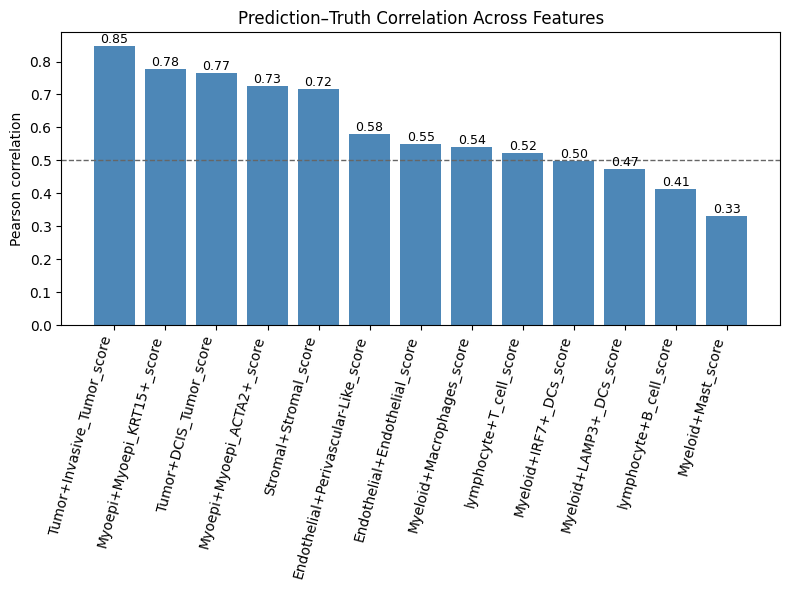

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(corr_df["feature"], corr_df["pearson"], color="steelblue", alpha=0.8)

plt.xticks(rotation=75, ha="right")
plt.ylabel("Pearson correlation")
plt.title("Prediction–Truth Correlation Across Features")
# plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axhline(0.5, color="#666666", linestyle="--", linewidth=1)

# === 在每个柱子上方标注数值 ===
for bar in plt.bar(corr_df["feature"], corr_df["pearson"], color="steelblue", alpha=0.8):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,       # x 坐标（柱子中点）
        height  if height >= 0 else height - 0.05,  # y 坐标（柱顶稍上）
        f"{height:.2f}",                         # 格式化为两位小数
        ha="center", va="bottom", fontsize=9, rotation=0
    )
    
plt.tight_layout()

plt.savefig('/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/regression_correlation_barplot.pdf',
            bbox_inches='tight',
            format='pdf',
            dpi=300)
plt.show()


### 4.2 绘制预测与真实值散点图

Top 2 correlated features: ['Tumor+Invasive_Tumor_score', 'Myoepi+Myoepi_KRT15+_score', 'Tumor+DCIS_Tumor_score', 'Myoepi+Myoepi_ACTA2+_score', 'Stromal+Stromal_score']


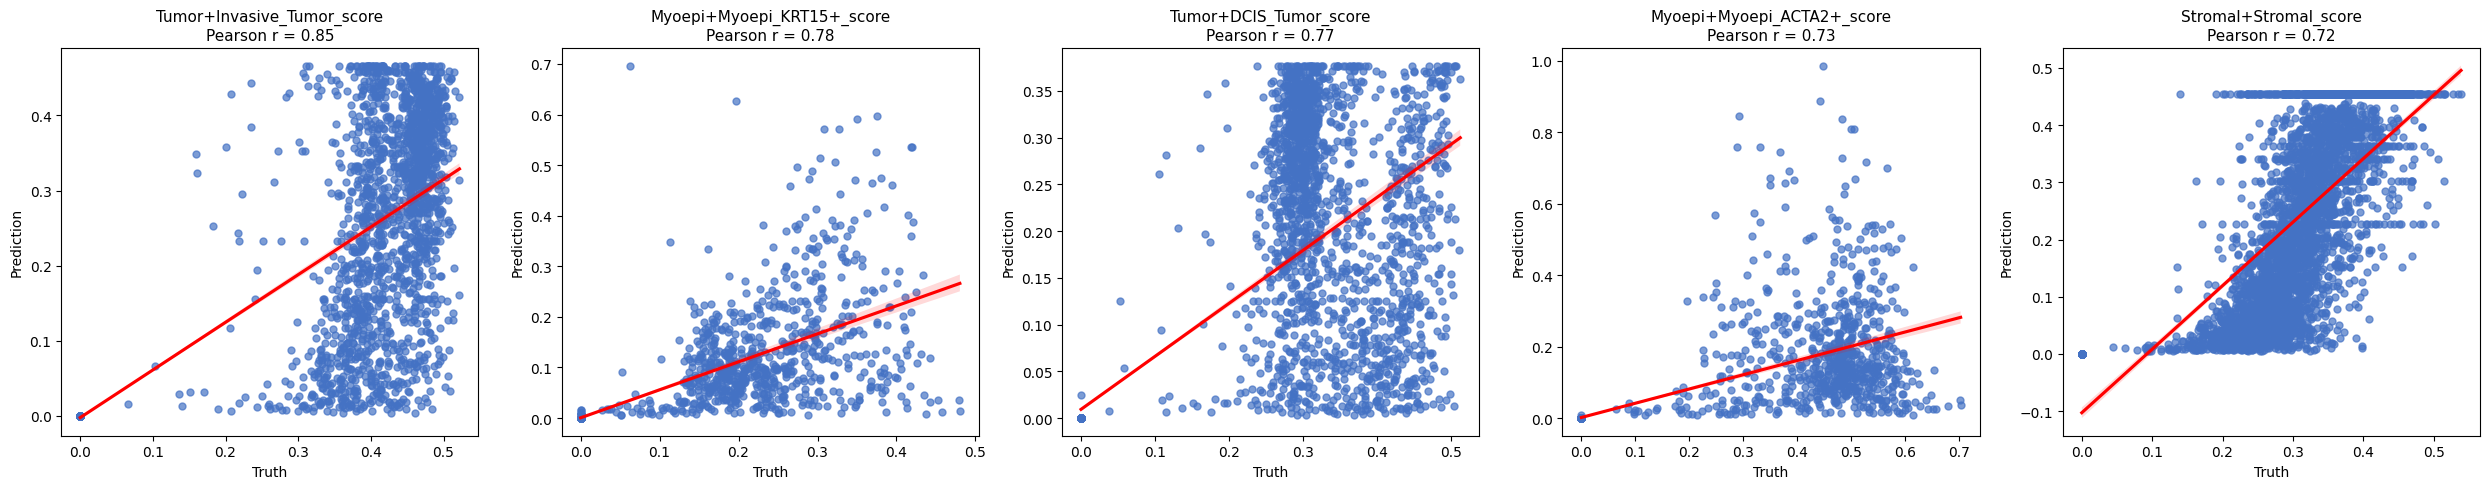

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn更适合画散点+回归线
import numpy as np

# === 1️⃣ 找到 Top 2 特征 ===
top2_features = corr_df.head(5)["feature"].tolist()
print("Top 2 correlated features:", top2_features)

# === 2️⃣ 绘图 ===
plt.figure(figsize=(25, 5))


for i, feature in enumerate(top2_features, 1):
    plt.subplot(1, 5, i)
    sns.regplot(
        x=truth[feature], 
        y=pred[feature],
        scatter_kws={"s": 25, "alpha": 0.7},
        line_kws={"color": "red"},
        color="#4472C4"
    )
    # 计算相关系数
    r = truth[feature].corr(pred[feature], method="pearson")
    
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.title(f"{feature}\nPearson r = {r:.2f}", fontsize=11)
    # plt.grid(alpha=0.3)
    # plt.xlim(0,1)
    # plt.ylim(0,1)

plt.tight_layout()

plt.savefig('/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/regression_scatter_top2_features.pdf',
            bbox_inches='tight',
            format='pdf',
            dpi=300)
plt.show()


### 4.3 绘制真实值、预测值、visium分解前值的切片可视化图

In [14]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# ===== 0) 你已有对象 =====
# adata_v: AnnData (Visium)，其中 adata_v.obs_names 是 spot 名
# truth, pred: 两个 DataFrame（index=spot，columns 含 'Tumor+Invasive_Tumor_score'）
# npz_path: 你的 npz 路径（包含 visium_score, spot_names, program_names 等）
npz_path = "/home/vs_theg/ST_program/CellType_GP/data/preprocessing_outputs/spot_data_full.npz"
adata_v = sc.read_h5ad("/home/vs_theg/ST_program/CellType_GP/data/vdata.h5")
# ===== 1) 目标列名（truth / pred 里已经是这个名字）
target_col = "Stromal+Stromal_score"

# 丢到 Series，并按 adata_v.obs_names 对齐（缺失填 0，必要时你也可以用 .dropna()）
truth_s = truth[target_col].reindex(adata_v.obs_names).fillna(0)
pred_s  = pred[target_col].reindex(adata_v.obs_names).fillna(0)

# ===== 2) 从 npz 里取 visium_score 的 Invasive_Tumor 分数（按 program 维）
data = np.load(npz_path, allow_pickle=True)
visium_score   = data["visium_score"]                 # (P, S) 每列一个 spot
spot_names     = data["spot_names"]                   # (S,)
program_names  = data["program_names"]                # (P,)

# 统一成 list，方便查找
program_names = list(program_names)

# 有的流水线 program_names 可能没有 "_score" 后缀，这里做个小助手：
def _normalize_name(name: str):
    return name.replace("_score", "")

# 找到 Invasive_Tumor 在 program_names 中的索引
pg_name = _normalize_name("Stromal_score")
try:
    pg_idx = program_names.index(pg_name)
except ValueError:
    # 如果 program_names 本身带了 _score，则再试一次
    try:
        pg_idx = program_names.index("Stromal_score")
    except ValueError as e:
        raise ValueError("在 program_names 中找不到 Invasive_Tumor（或 Invasive_Tumor_score）") from e

# 把 visium_score 第 pg_idx 行变成 Series，并对齐 adata 的 spot 顺序
# 注意：visium_score 维度为 (P, S)，spot_names 对应列顺序
visium_df = pd.DataFrame(visium_score.T, index=spot_names, columns=program_names)  # (S, P)
visium_s  = visium_df.iloc[:, pg_idx].reindex(adata_v.obs_names).fillna(0)


In [18]:

# ===== 3) 塞进 adata_v.obs（列名清晰一些）
adata_v.obs["truth_Stromal+Stromal_score"] = truth_s.astype(float)
adata_v.obs["pred_Stromal+Stromal_score"]  = pred_s.astype(float)
adata_v.obs["visium_Stromal_score"]      = visium_s.astype(float)

# ===== 4) 画切片空间热图（并排/单图都可）
# 并排 3 图（推荐汇报）
cols = ["truth_Stromal+Stromal_score",
        "pred_Stromal+Stromal_score",
        "visium_Stromal_score",]

vmin = 0.0
vmax = max(adata_v.obs[c].max() for c in cols)

sc.pl.spatial(
    adata_v,
    color=[
        "truth_Stromal+Stromal_score",
        "pred_Stromal+Stromal_score",
        "visium_Stromal_score",
    ],
    ncols=3,
    vmin=vmin,
    vmax=vmax,
    show=False
    # spot_size=1.2,   # 视你的数据微调
    # cmap="inferno",  # 热图风格；也可用 "viridis"
)

plt.savefig('/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/spatial_Stromal+Stromal_score.pdf',
            bbox_inches='tight', 
            format='pdf',
            dpi=300)

plt.close()
# 如需单幅逐张看，也可以分别：
# sc.pl.spatial(adata_v, color="truth_Tumor+Invasive_Tumor_score", spot_size=1.2, cmap="inferno")
# sc.pl.spatial(adata_v, color="pred_Tumor+Invasive_Tumor_score",  spot_size=1.2, cmap="inferno")
# sc.pl.spatial(adata_v, color="visium_Invasive_Tumor_score",      spot_size=1.2, cmap="inferno")


In [12]:
import numpy as np
import scanpy as sc

cols = [
    "truth_Tumor+Invasive_Tumor_score",
    "pred_Tumor+Invasive_Tumor_score",
    "visium_Invasive_Tumor_score",
]

# 统一色标范围，便于对比
vmin = 0.0
vmax = max(adata_v.obs[c].max() for c in cols)

# 如果你的切片里有多个库，指定 library_id；img_key 选你上面打印看到的键
img_key = "hires"       # 或 "lowres"

sc.pl.spatial(
    adata_v,
    color=cols,
    ncols=3,
    # spot_size=1.3,
    # cmap="inferno",
    vmin=vmin,
    vmax=vmax,
    img_key=img_key,
    show=False
)


plt.savefig('/home/vs_theg/ST_program/CellType_GP/data/notebook_outputs/spatial_Tumor_Invasive_Tumor_score.pdf',
            bbox_inches='tight', 
            format='pdf',
            dpi=300)

plt.close()